In [ ]:
!python --version
%pip install -r requirements.txt

In [1]:
import tensorflow as tf
import sklearn as pd
import keras
keras.__version__

#pd.__version__

Using TensorFlow backend.


'2.4.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [4]:
DEVICE = "/gpu:0" 

In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
print(np.__version__)
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


1.19.5


In [6]:

class CustomConfig(Config):
    NAME = "object"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2 
    STEPS_PER_EPOCH = 10
    DETECTION_MIN_CONFIDENCE = 0.9
    

In [7]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

'''


model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
'''



from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=DEFAULT_LOGS_DIR, config=inference_config)
model_path = model.find_last()
print("Loading weights from ", model_path)

# Load weights trained on MS-COCO
# model.load_weights(COCO_MODEL_PATH, by_name=True)


model.keras_model.load_weights(model_path, by_name=True, skip_mismatch=True)


#import tensorflow.compat.v1 as tfc

#tfc.keras.Model.load_weights(model.keras_model, model_path, by_name=True)





Instructions for updating:
Use fn_output_signature instead
Loading weights from  c:\Users\angad\Downloads\Mask-R-CNN-using-Tensorflow2-main\Mask-R-CNN-using-Tensorflow2-main\logs\object20231029T1204\mask_rcnn_object_0500.h5


In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        self.add_class("object", 1, "500_front")
        self.add_class("object", 2, "500_back")


     
        # Train or validation dataset
        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations1 = json.load(open('./dataset/'+subset+'/train.json'))
        
        annotations = list(annotations1['_via_img_metadata'].values())  

        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            a_regions = []
            m_region = len(a['regions'])
            for i in range(m_region):
                a_regions.append(a['regions'][i])
            polygons = [r['shape_attributes'] for r in a_regions] 
            objects = [s['region_attributes']['name'] for s in a_regions]
            print("objects:",objects)
            name_dict = {"500_front": 1,"500_back": 2}
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  
                image_id=a['filename'],  
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            if rr is not None and cc is not None:
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [9]:
dataset_train = CustomDataset()
dataset_train.load_custom("./dataset", "train")
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_custom("./dataset", "val")
dataset_val.prepare()

objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_front']
numids [1]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_back']
numid

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  199.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 5344.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   98.00000  max:  758.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


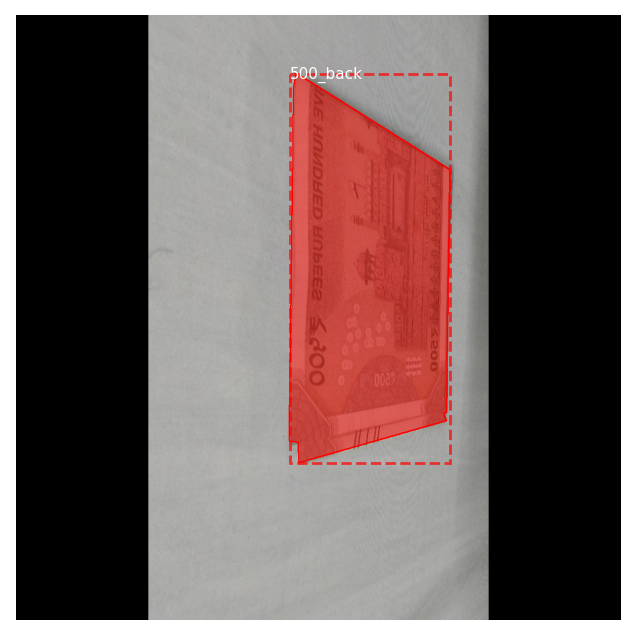

In [10]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

Processing 1 images
image                    shape: (5344, 3006, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  122.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 5344.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


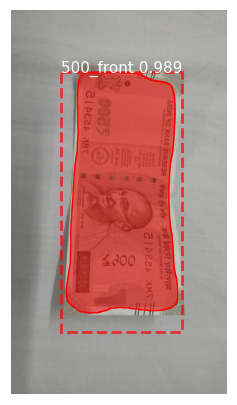

Processing 1 images
image                    shape: (3006, 5344, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 5344.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


KeyboardInterrupt: 

In [11]:
import skimage
real_test_dir = './dataset/val'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    if img.shape[-1] == 4:
        img = img[..., :3]
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_front']
numids [1]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
objects: ['500_back']
numids [2]
Processing 1 images
image                    shape: (505, 758, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


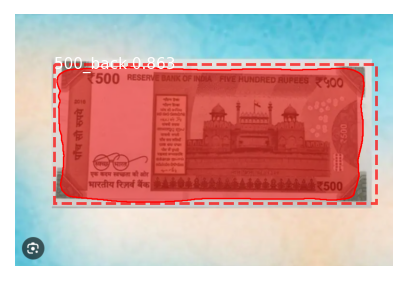

Processing 1 images
image                    shape: (521, 523, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


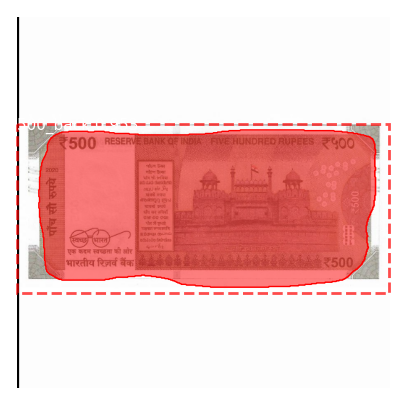

Processing 1 images
image                    shape: (522, 652, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


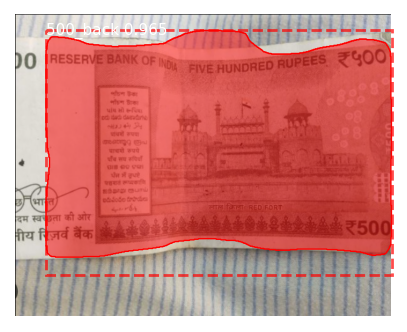

Processing 1 images
image                    shape: (428, 605, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


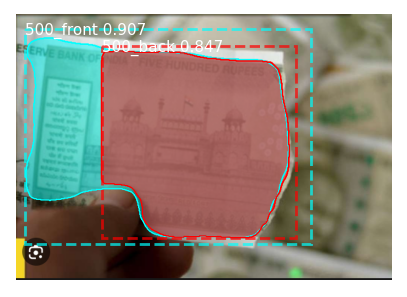

Processing 1 images
image                    shape: (432, 335, 3)         min:    9.00000  max:  223.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  118.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


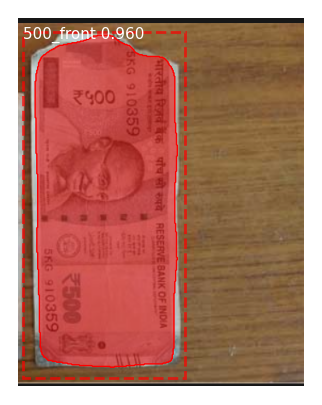

Processing 1 images
image                    shape: (428, 191, 3)         min:    1.00000  max:  219.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  113.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


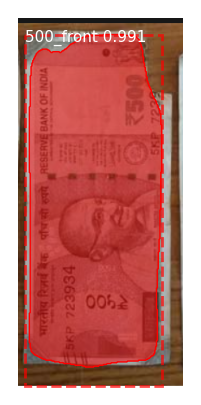

Processing 1 images
image                    shape: (432, 772, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


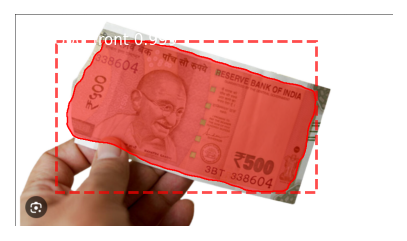

Processing 1 images
image                    shape: (391, 377, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


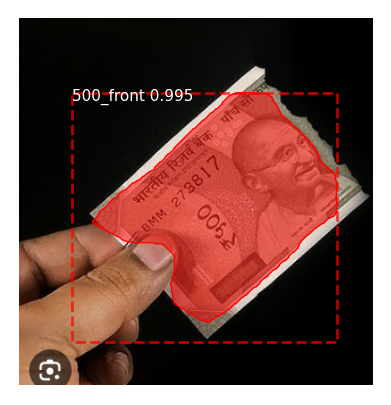

Processing 1 images
image                    shape: (440, 302, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


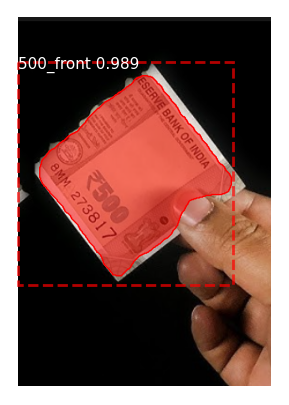

Processing 1 images
image                    shape: (330, 447, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


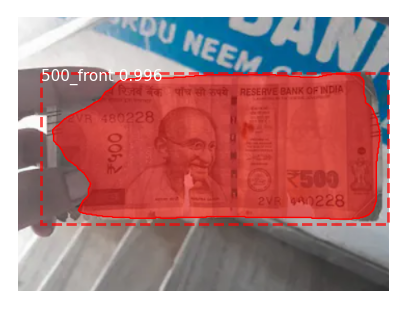

In [ ]:
from matplotlib import pyplot as plt
from PIL import ImageChops, Image


ctr_imgs = 0
ratio=0.75
min_match=10
sift=cv2.SIFT_create()
smoothing_window_size=700
left_image_opacity = 0.4
right_image_opacity = 0.6

def remove_black(img, opacity):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 255*opacity-1, 255*opacity, cv2.THRESH_BINARY)
    img[thresh == 255*opacity] = 0
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    erosion = cv2.erode(img, kernel, iterations = 1)
    return erosion


def get_area(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.countNonZero(gray)

def segment(image, r):
    idx = r['scores'].argmax()
    mask = r['masks'][:,:,idx]
    mask = np.stack((mask,)*3, axis=-1)
    mask.astype('uint8')
    bg = 255 - mask*255
    mask_img = image*mask
    result = mask_img + bg
    return result


def registration(img1,img2):
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    matcher = cv2.BFMatcher()
    raw_matches = matcher.knnMatch(des1, des2, k=2)
    good_points = []
    good_matches=[]
    for m1, m2 in raw_matches:
        if m1.distance < ratio * m2.distance:
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
    cv2.imwrite('homography_matching.jpg', img3)
    if len(good_points) > min_match:
        image1_kp = np.float32(
            [kp1[i].pt for (_, i) in good_points])
        image2_kp = np.float32(
            [kp2[i].pt for (i, _) in good_points])
        H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
    return H


def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        # mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        # mask[:, :barrier - offset] = 1

        mask[:, :] = left_image_opacity

    else:
        # mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        # mask[:, barrier + offset:] = 1

        mask[:, :] = right_image_opacity
    return cv2.merge([mask, mask, mask])


def blending(img1,img2):
    H = registration(img1,img2)
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2

    panorama1 = np.zeros((height_panorama, width_panorama, 3))
    mask1 = create_mask(img1,img2,version='left_image')
    panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
    panorama1 *= mask1
    # panorama1 = remove_black(panorama1.astype(np.uint8), left_image_opacity)
    area_truth = get_area(panorama1.astype(np.uint8))
    # cv2.imwrite("test1-"+str(ctr_imgs)+".jpg",panorama1)

    mask2 = create_mask(img1,img2,version='right_image')
    panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
    panorama2 = remove_black(panorama2.astype(np.uint8), right_image_opacity)
    area_detected = get_area(panorama2.astype(np.uint8))
    # cv2.imwrite("test2-"+str(ctr_imgs)+".jpg",panorama2)
    
    result=panorama1+panorama2
    result_area = round((area_detected/area_truth) * 100, 2)
    # cv2.imwrite("test3-"+str(ctr_imgs)+".jpg",result)
    # print("Percentage Note:", result_area)

    rows, cols = np.where(result[:, :, 0] != 0)
    min_row, max_row = min(rows), max(rows) + 1
    min_col, max_col = min(cols), max(cols) + 1
    final_result = result[min_row:max_row, min_col:max_col, :]
    return final_result, result_area




dataset_test = CustomDataset()
dataset_test.load_custom("./dataset", "test")
dataset_test.prepare()

real_test_dir = './dataset/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    if img.shape[-1] == 4:
        img = img[..., :3]
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    segmented_img = segment(img,r)

    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_test.class_names, r['scores'], figsize=(5,5))
    

    # plt.imshow(segmented_img)



    for i in range(r['rois'].shape[0]):
        if not np.any(r['rois'][i]) or dataset_test.class_names[r['class_ids'][i]] == 'BG':
            continue
        
        img1 = cv2.imread("./dataset/truth/"+dataset_test.class_names[r['class_ids'][i]]+".jpg")
        img2 = skimage.util.img_as_ubyte(segmented_img)

        final,area = blending(img1,img2)


        h,w,c = final.shape
        img_save = cv2.putText(
            img = final,
            text = "Percentage: "+str(area),
            org = (50, 50),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = 1.0,
            color = (0, 0, 255),
            thickness = 3
            )


        cv2.imwrite("panorama"+str(ctr_imgs)+".jpg", img_save)
        ctr_imgs+=1


In [ ]:
#!pip install numpy==1.20.3
#!pip install seaborn
#!pip install sklearn
#!pip install scikit-learn

# Confusion Matrix on Validation Dataset


In [ ]:
config=inference_config
dataset = dataset_val


gt_tot = np.array([])
pred_tot = np.array([])
mAP_ = []

for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)
    info = dataset.image_info[image_id]

    results = model.detect([image], verbose=1)
    r = results[0]
    
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))

import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


In [ ]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","hardhat","safety vest"] ,fz=18, figsize=(20,20), lw=0.5)

In [ ]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

# # Draw precision-recall curve  

##### The PR curve is for single detected image 

In [ ]:

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# calculate the mAP for a batch of validation images

In [ ]:
path = os.getcwd()
data_path = os.path.join(path + '/dataset')
model_path = os.path.join(path + '/logs/object20230216T1912')
weights_path = os.path.join(model_path + '/mask_rcnn_object_0300.h5')

DEVICE = "/gpu:0" 


config=inference_config
dataset = dataset_val


with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config)

model.load_weights(weights_path, by_name=True)

    
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls

#dataset.load_nucleus(data_path, 'val')
#dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Loading weights ", weights_path)

image_ids = np.random.choice(dataset.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()
    
    
    

# Load a random image from the images folder and perform prediction

In [ ]:

# IMAGE_DIR = os.path.join(ROOT_DIR, "test_images")

# # COCO Class names
# # Index of the class in the list is its ID. For example, to get ID of
# # the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'Hard_hat', 'Safety_vest']

# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])